In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

In [2]:
plt.rcParams['axes.facecolor'] = '#eeeeee'
plt.rcParams['axes.edgecolor'] = '#bcbcbc'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = 'black'
plt.rcParams['legend.fancybox'] = True

# Plan

**Model assumptions**
- Each reviwer can give a rating from 1 to 5.
- Rating distribution $r=[0, 3, 1, 2, 4]$ means absolute counts of ratings, i.e., 6 reviewers gave 5 stars, 2 reviewers - 4 stars, etc.
    - Avg. rating is the average of the rating counts, e.g., $(1\cdot 0 + 2\cdot 3 + 3\cdot 1 + 4\cdot 2 + 5\cdot 4)/(0+3+1+2+4) = 3.7$
- Rating counts $R$ ~ $Multinomial(R \mid N, p)$, where rating $R$ is a random variable and probability vector $p$ is a distr. parameter
    - $R = (r_1, r_2, r_3, r_4, r_5)$ - rating counts for a restaurant
    - $p = (p_1, p_2, p_3, p_4, p_5)$ where $p_i$ is a probability of rating $i$ for a restaurant
    - $N$ - total number of reviews for a restaurant
- Prior probabilities before reviews $p$ ~ Uniform 5-dim distr., i.e., all ratings are equally possible
- Probabilities $p$ ~ $Dirichlet(p\mid \alpha)$, where $p$ is a random variable and $\alpha$ is a distr. parameter
    - $\alpha = (\alpha_1, \alpha_2, \alpha_3, \alpha_4, \alpha_5)$

**Model - Multinomial–Dirichlet distribution**
- Dirichlet distr. is a conjugate distribution to the Multinomial distr. 
- Prior uniform probabilities $p$ ~ $Dirichlet(p, (1, 1, 1, 1, 1))$
- Posterior probabilities $p$ follow Dirichlet distr. with parameters updated from observed rating counts $r = (r_1, r_2, r_3, r_4, r_5)$: 
$$P(p | r) = Dirichlet(p\mid 1+r)$$

**How to compare 2 restaurants**
- Restaurant A is better than restarant B means that $P(E(R_A)>E(R_B))$
- Avg. posterior rating $E(R_A) = 1\cdot p_1 + 2\cdot p_2 + 3\cdot p_3 + 4\cdot p_4 + 5\cdot p_5$, where $p_i$ are posterior probabilities we will sample from posterior Dirichlet distr. for restaurant A

# Observed reviews

In [3]:
def get_multinomial_reviews_data(shape: list, n_reviews: int) -> tuple[list, float, float]:
    """
    Helper function that converts distribution shape with the reviews count (actual observed data) 
    into a sample from a multinomial distribution.
    
    Args: 
        shape (list): [0, 1, 1, 2, 6]
        n_review (int): 100

    Returns:
        list: [0, 10, 10, 20, 60] - counts
        float: 4.3 - mean
        float: 1.0 - std
    """
    reviews_shape = np.array(shape)
    reviews_distr = reviews_shape/sum(reviews_shape)
    sample = reviews_distr*n_reviews
    sample = np.array(list(map(int, sample)))
    sample_mean = sum((r+1)*p for r, p in enumerate(reviews_distr))
    sample_std = np.sqrt(sum(p*(r+1-sample_mean)**2 for r, p in enumerate(reviews_distr)))
    return sample, sample_mean, sample_std

In [4]:
reviews_a, reviews_a_mean, reviews_a_std = get_multinomial_reviews_data(shape=[0, 0, 0, 0, 1], n_reviews=10)
reviews_b, reviews_b_mean, reviews_b_std = get_multinomial_reviews_data(shape=[4, 1, 2, 15, 16], n_reviews=202)

print(f'A reviews: {list(reviews_a)}, total: {sum(reviews_a)}, mean: {reviews_a_mean}, std: {reviews_a_std:.2f}')
print(f'B reviews: {list(reviews_b)}, total: {sum(reviews_b)}, mean: {reviews_b_mean}, std: {reviews_b_std:.2f}')

A reviews: [0, 0, 0, 0, 10], total: 10, mean: 5.0, std: 0.00
B reviews: [21, 5, 10, 79, 85], total: 200, mean: 4.0, std: 1.24


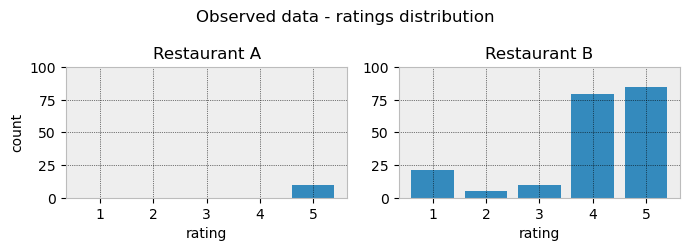

In [5]:
# plot observed reviews
figsize(7, 4)

plt.subplot(221)
plt.bar(np.arange(1, 6), reviews_a, color="#348ABD")
plt.ylim(0, 100)
plt.xlabel("rating")
plt.ylabel("count")
plt.title("Restaurant A")

plt.subplot(222)
plt.bar(np.arange(1, 6), reviews_b, color="#348ABD")
plt.ylim(0, 100)
plt.xlabel("rating")
# plt.ylabel("count")
plt.title("Restaurant B")

plt.suptitle("Observed data - ratings distribution")
plt.tight_layout()

# Prior distribution

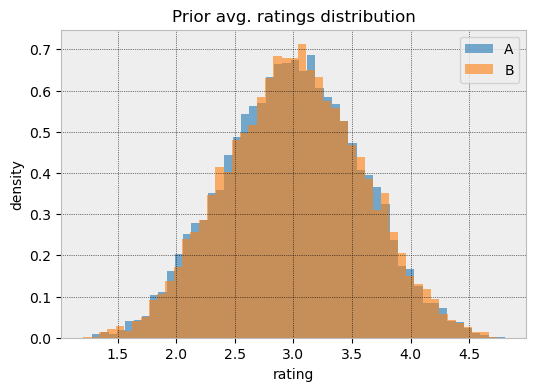

In [6]:
# Prior average rating distribution uniform

# prior prob. estimates sampling from uniform
sample_size = 10000
p_a = np.random.dirichlet(np.ones(5), size=sample_size)
p_b = np.random.dirichlet(np.ones(5), size=sample_size)

# calculate prior ratings' means based on sampled probs
ratings_support = np.array([1, 2, 3, 4, 5])
prior_reviews_mean_a = np.dot(p_a, ratings_support)
prior_reviews_mean_b = np.dot(p_b, ratings_support)

# plot prior ratings' means
plt.figure(figsize=(6, 4))
plt.hist(prior_reviews_mean_a, bins=50, density=True, alpha=0.6, label='A')
plt.hist(prior_reviews_mean_b, bins=50, density=True, alpha=0.6, label='B')
plt.xlabel("rating")
plt.ylabel("density")
plt.title("Prior avg. ratings distribution")
plt.legend()

# Posterior distribution

In [7]:
# sample posterior estimates of ratings probabilities based on observed
sample_size = 10000
p_a = np.random.dirichlet(reviews_a+1, size=sample_size)
p_b = np.random.dirichlet(reviews_b+1, size=sample_size)

# calculate posterior ratings' means   
posterior_reviews_mean_a = np.dot(p_a, ratings_support)
posterior_reviews_mean_b = np.dot(p_b, ratings_support)

# mean
print(f'A - avg. rating: observed {reviews_a_mean:.4f}, posterior: {posterior_reviews_mean_a.mean():.4f}')
print(f'B - avg. rating: observed {reviews_b_mean:.4f}, posterior: {posterior_reviews_mean_b.mean():.4f}')

A - avg. rating: observed 5.0000, posterior: 4.3285
B - avg. rating: observed 4.0000, posterior: 3.9846


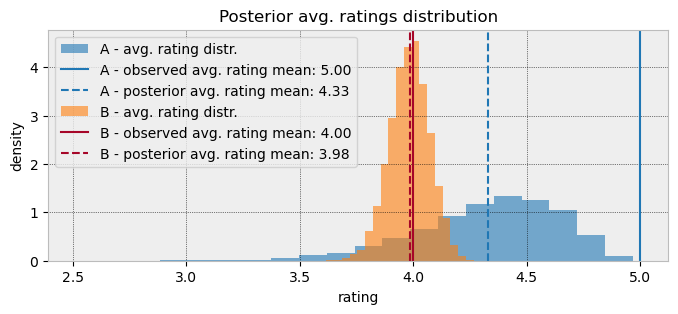

In [8]:
plt.figure(figsize=(8, 3))
plt.hist(posterior_reviews_mean_a, bins=20, density=True, alpha=0.6, label='A - avg. rating distr.')
plt.axvline(reviews_a_mean, linestyle="-", label=f"A - observed avg. rating mean: {reviews_a_mean:.2f}")
plt.axvline(posterior_reviews_mean_a.mean(), linestyle="--", label=f"A - posterior avg. rating mean: {posterior_reviews_mean_a.mean():.2f}")
plt.hist(posterior_reviews_mean_b, bins=20, density=True, alpha=0.6, label='B - avg. rating distr.')
# plt.vlines(reviews_b_mean, 0, 10, linestyle="--", colors="#A60628", label="B - observed reviews mean")
plt.axvline(reviews_b_mean, linestyle="-", color="#A60628", label=f"B - observed avg. rating mean: {reviews_b_mean:.2f}")
plt.axvline(posterior_reviews_mean_b.mean(), linestyle="--", color="#A60628", label=f"B - posterior avg. rating mean: {posterior_reviews_mean_b.mean():.2f}")
plt.xlabel("rating")
plt.ylabel("density")
plt.title("Posterior avg. ratings distribution")
plt.legend()

p(E(A)>E(B)): 0.8538


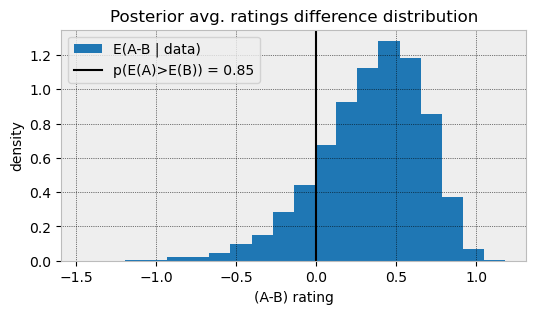

In [9]:
# prob that posterior mean review of A is better than the posterior mean review of B
posterior_rating_diff = posterior_reviews_mean_a-posterior_reviews_mean_b
p_posterior_better = sum(posterior_rating_diff>0)/len(posterior_rating_diff)
# p_posterior_better = sum(posterior_reviews_mean_a>posterior_reviews_mean_b)/sample_size

print('p(E(A)>E(B)):', p_posterior_better)

plt.figure(figsize=(6, 3))
plt.hist(posterior_rating_diff, bins=20, density=True, label='E(A-B | data)')
plt.axvline(x=0, color='k', label=f'p(E(A)>E(B)) = {p_posterior_better:.2f}')
plt.xlabel("(A-B) rating")
plt.ylabel("density")
plt.title("Posterior avg. ratings difference distribution")
plt.legend()